In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 

import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from hmmlearn import hmm

In [22]:
df = pd.read_excel('Datasets/MunicipiosSequia.xlsx')

In [23]:
df.head()

,CVE_CONCATENADA,CVE_ENT,CVE_MUN,NOMBRE_MUN,ENTIDAD,ORG_CUENCA*,CLV_OC,CON_CUENCA,CVE_CONC,2003-01-31 00:00:00,...,2024-01-31 00:00:00,2024-02-15 00:00:00,2024-02-29 00:00:00,2024-03-15 00:00:00,2024-03-31 00:00:00,2024-04-15 00:00:00,2024-04-30 00:00:00,2024-05-15 00:00:00,2024-05-31 00:00:00,2024-06-15 00:00:00
0,1001,1,1,Aguascalientes,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D2,D2,D2,D2,D2,D2,D2,D3
1,1002,1,2,Asientos,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,D2,D2,D0,D0,D0,D1,D1,D1,D1,D1
2,1003,1,3,Calvillo,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D3,D3
3,1004,1,4,Cosío,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D2,D1,D1,D1,D2,D2,D2,D2,D2
4,1005,1,5,Jesús María,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D3,D3


In [24]:
df.columns

Index([  'CVE_CONCATENADA',           'CVE_ENT',           'CVE_MUN',
              'NOMBRE_MUN',           'ENTIDAD',       'ORG_CUENCA*',
                  'CLV_OC',        'CON_CUENCA',          'CVE_CONC',
       2003-01-31 00:00:00,
       ...
       2024-01-31 00:00:00, 2024-02-15 00:00:00, 2024-02-29 00:00:00,
       2024-03-15 00:00:00, 2024-03-31 00:00:00, 2024-04-15 00:00:00,
       2024-04-30 00:00:00, 2024-05-15 00:00:00, 2024-05-31 00:00:00,
       2024-06-15 00:00:00],
      dtype='object', length=390)

### Nombres de las Columnas

In [25]:
diccionario = {'CVE_CONCATENADA',           'CVE_ENT',           'CVE_MUN',
              'NOMBRE_MUN',           'ENTIDAD',       'ORG_CUENCA*',
                  'CLV_OC',        'CON_CUENCA',          'CVE_CONC'}

In [26]:
df['CLV_OC'].unique()

array(['VIII', 'I', 'XII', 'XI', 'VI', 'VII', 'III', 'II', 'XIII', 'IX',
       'V', 'IV', 'X'], dtype=object)

In [27]:
Mapeos_claves_entidad = {
    "001": "AGUASCALIENTES",
    "002": "BAJA CALIFORNIA",
    "003": "BAJA CALIFORNIA SUR",
    "004": "CAMPECHE",
    "005": "COAHUILA DE ZARAGOZA",
    "006": "COLIMA",
    "007": "CHIAPAS",
    "008": "CHIHUAHUA",
    "009": "DISTRITO FEDERAL",
    "010": "DURANGO",
    "011": "GUANAJUATO",
    "012": "GUERRERO",
    "013": "HIDALGO",
    "014": "JALISCO",
    "015": "MEXICO",
    "016": "MICHOACAN DE OCAMPO",
    "017": "MORELOS",
    "018": "NAYARIT",
    "019": "NUEVO LEON",
    "020": "OAXACA",
    "021": "PUEBLA",
    "022": "QUERETARO DE ARTEAGA",
    "023": "QUINTANA ROO",
    "024": "SAN LUIS POTOSI",
    "025": "SINALOA",
    "026": "SONORA",
    "027": "TABASCO",
    "028": "TAMAULIPAS",
    "029": "TLAXCALA",
    "030": "VERACRUZ DE IGNACIO DE LA LLAVE",
    "031": "YUCATAN",
    "032": "ZACATECAS"
}

mapeo = {
    'D0': 0,
    'D1': 1,
    'D2': 2,
    'D3': 3,
    'D4': 4,
    'NaN': np.nan
}

mapeo_inverso = {0: 'D0', 1: 'D1', 2: 'D2', 3: 'D3', 4: 'D4', np.nan: 'NaN'}

#### Modelacion de una Cadena de Markov Oculta FORECAST:

In [28]:
#################Reemplazar los valores categóricos en las columnas de series de tiempo
for col in df.columns[9:]:
    df[col] = df[col].map(mapeo)

In [29]:
#CategoricalHMM
def modelar_serie_tiempo_hmm(serie, n_components=4):
    #########Remover valores NaN para entrenar el modelo
    serie = serie.dropna().values.reshape(-1, 1).astype(int)
    
    ##########Ajustar el modelo HMM
    modelo = hmm.CategoricalHMM(n_components=n_components, n_iter=500)
    modelo.fit(serie)
    
    #########Predicción
    prediccion, _ = modelo.sample(24)  # Predicción para los próximos 24 periodos
    return prediccion

##############Iterar sobre cada fila y modelar la serie de tiempo
resultados = []

for index, row in df.iterrows():
    #########Extraer la serie de tiempo (todas las columnas de fecha)
    serie_tiempo = row.iloc[9:].dropna().astype(int)  ######3Asegúrate de ajustar el índice de columna si es necesario
    prediccion = modelar_serie_tiempo_hmm(serie_tiempo)
    
    #######3Almacenar los resultados
    resultados.append({
        'CVE_CONCATENADA': row['CVE_CONCATENADA'],
        'CVE_Entidad': row['CVE_ENT'],
        'ENTIDAD': row['ENTIDAD'],
        'CVE_MUN': row['CVE_MUN'],
        'NOMBRE_MUN' : row['NOMBRE_MUN'],
        'Prediccion': prediccion.flatten().tolist()
    })

#####3Convertir los resultados en un DataFrame
resultados_df = pd.DataFrame(resultados)

#####Mostrar los resultados
print(resultados_df)

      CVE_CONCATENADA  CVE_Entidad         ENTIDAD  CVE_MUN  \
0                1001            1  Aguascalientes        1   
1                1002            1  Aguascalientes        2   
2                1003            1  Aguascalientes        3   
3                1004            1  Aguascalientes        4   
4                1005            1  Aguascalientes        5   
...               ...          ...             ...      ...   
2466            32054           32       Zacatecas       54   
2467            32055           32       Zacatecas       55   
2468            32056           32       Zacatecas       56   
2469            32057           32       Zacatecas       57   
2470            32058           32       Zacatecas       58   

                 NOMBRE_MUN                                         Prediccion  
0            Aguascalientes  [0, 0, 1, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, ...  
1                  Asientos  [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, ...  


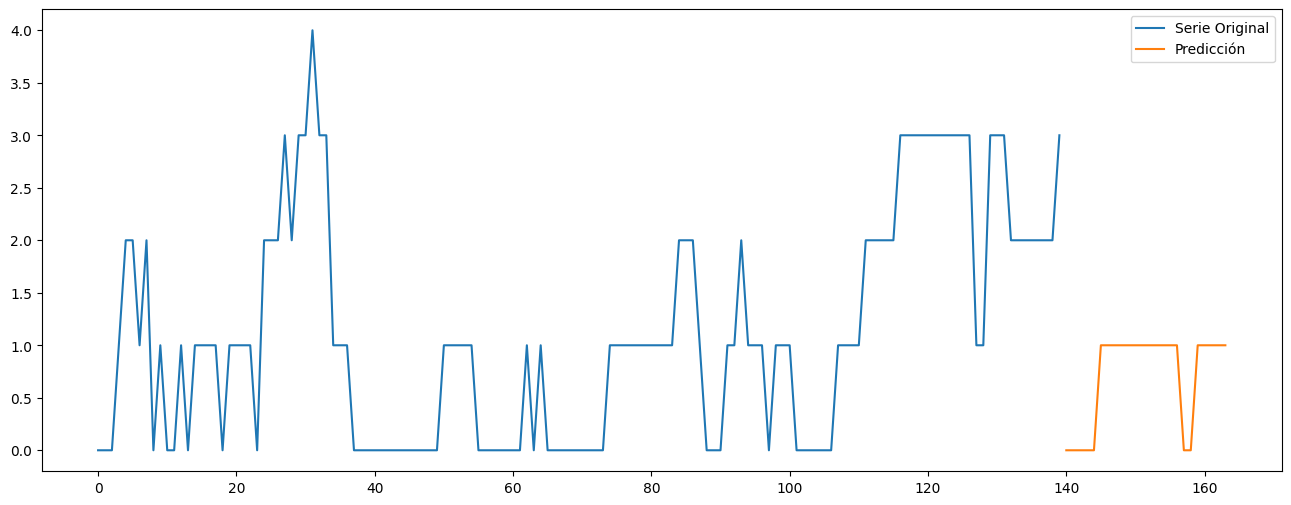

In [30]:
ejemplo_serie = df.iloc[0, 9:].dropna().astype(int)
ejemplo_prediccion = resultados_df.iloc[691]['Prediccion']


plt.figure(figsize=(16, 6))
plt.plot(range(len(ejemplo_serie)), ejemplo_serie, label='Serie Original')
plt.plot(range(len(ejemplo_serie), len(ejemplo_serie) + len(ejemplo_prediccion)), ejemplo_prediccion, label='Predicción')
plt.legend()
plt.show()

In [31]:
resultados_df.head(50)

,CVE_CONCATENADA,CVE_Entidad,ENTIDAD,CVE_MUN,NOMBRE_MUN,Prediccion
0,1001,1,Aguascalientes,1,Aguascalientes,"[0, 0, 1, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, ..."
1,1002,1,Aguascalientes,2,Asientos,"[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, ..."
2,1003,1,Aguascalientes,3,Calvillo,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ..."
3,1004,1,Aguascalientes,4,Cosío,"[2, 0, 2, 0, 1, 1, 1, 1, 1, 0, 3, 0, 2, 2, 2, ..."
4,1005,1,Aguascalientes,5,Jesús María,"[0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, ..."
5,1006,1,Aguascalientes,6,Pabellón de Arteaga,"[0, 1, 1, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, ..."
6,1007,1,Aguascalientes,7,Rincón de Romos,"[0, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 2, 3, 3, 2, ..."
7,1008,1,Aguascalientes,8,San José de Gracia,"[0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, ..."
8,1009,1,Aguascalientes,9,Tepezalá,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
9,1010,1,Aguascalientes,10,El Llano,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ..."


In [32]:
len(df.columns)

390

In [33]:
resultados_df

,CVE_CONCATENADA,CVE_Entidad,ENTIDAD,CVE_MUN,NOMBRE_MUN,Prediccion
0,1001,1,Aguascalientes,1,Aguascalientes,"[0, 0, 1, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, ..."
1,1002,1,Aguascalientes,2,Asientos,"[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, ..."
2,1003,1,Aguascalientes,3,Calvillo,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ..."
3,1004,1,Aguascalientes,4,Cosío,"[2, 0, 2, 0, 1, 1, 1, 1, 1, 0, 3, 0, 2, 2, 2, ..."
4,1005,1,Aguascalientes,5,Jesús María,"[0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, ..."
...,...,...,...,...,...,...
2466,32054,32,Zacatecas,54,Villa Hidalgo,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ..."
2467,32055,32,Zacatecas,55,Villanueva,"[0, 0, 2, 2, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, ..."
2468,32056,32,Zacatecas,56,Zacatecas,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2469,32057,32,Zacatecas,57,Trancoso,"[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."


In [34]:
#Dividir la columna 'Prediccion' en múltiples columnas
predicciones_df = pd.DataFrame(resultados_df['Prediccion'].tolist(), columns=[f'Prediccion_{i+1}' for i in range(len(resultados_df['Prediccion'].iloc[0]))])

In [35]:
resultados_df = pd.concat([df, predicciones_df], axis=1)

In [36]:
len(df.columns)

390

In [37]:
resultados_numericos = resultados_df.copy() 

In [38]:
resultados_finales = resultados_df.copy()

In [39]:
resultados_numericos

,CVE_CONCATENADA,CVE_ENT,CVE_MUN,NOMBRE_MUN,ENTIDAD,ORG_CUENCA*,CLV_OC,CON_CUENCA,CVE_CONC,2003-01-31 00:00:00,...,Prediccion_15,Prediccion_16,Prediccion_17,Prediccion_18,Prediccion_19,Prediccion_20,Prediccion_21,Prediccion_22,Prediccion_23,Prediccion_24
0,1001,1,1,Aguascalientes,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,3,3,2,3,2,2,1,0,0,0
1,1002,1,2,Asientos,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,1,1,1,0,0,0,0,0,0,0
2,1003,1,3,Calvillo,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,2,1,0,0,0,0,1,1,0,1
3,1004,1,4,Cosío,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,2,0,2,2,0,3,3,2,0,0
4,1005,1,5,Jesús María,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,1,1,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,32054,32,54,Villa Hidalgo,Zacatecas,Cuencas Centrales Del Norte,VII,Del Altiplano,14,NaN,...,1,1,1,2,1,1,0,0,0,1
2467,32055,32,55,Villanueva,Zacatecas,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,0,0,0,1,0,1,0,1,1,0
2468,32056,32,56,Zacatecas,Zacatecas,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,0,1,1,1,1,1,1,1,1,0
2469,32057,32,57,Trancoso,Zacatecas,Cuencas Centrales Del Norte,VII,Del Altiplano,14,NaN,...,0,0,0,0,0,0,0,0,0,1


In [41]:
#Aplicamos el mapeo inverso a cada columna del DataFrame
for columna in resultados_finales.columns[9:]:
    resultados_finales[columna] = resultados_finales[columna].map(mapeo_inverso)

In [42]:
resultados_finales

,CVE_CONCATENADA,CVE_ENT,CVE_MUN,NOMBRE_MUN,ENTIDAD,ORG_CUENCA*,CLV_OC,CON_CUENCA,CVE_CONC,2003-01-31 00:00:00,...,Prediccion_15,Prediccion_16,Prediccion_17,Prediccion_18,Prediccion_19,Prediccion_20,Prediccion_21,Prediccion_22,Prediccion_23,Prediccion_24
0,1001,1,1,Aguascalientes,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D2,D3,D2,D2,D1,D0,D0,D0
1,1002,1,2,Asientos,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,D1,D1,D1,D0,D0,D0,D0,D0,D0,D0
2,1003,1,3,Calvillo,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,D2,D1,D0,D0,D0,D0,D1,D1,D0,D1
3,1004,1,4,Cosío,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,D2,D0,D2,D2,D0,D3,D3,D2,D0,D0
4,1005,1,5,Jesús María,Aguascalientes,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,D1,D1,D0,D0,D0,D0,D1,D1,D1,D1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,32054,32,54,Villa Hidalgo,Zacatecas,Cuencas Centrales Del Norte,VII,Del Altiplano,14,NaN,...,D1,D1,D1,D2,D1,D1,D0,D0,D0,D1
2467,32055,32,55,Villanueva,Zacatecas,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,D0,D0,D0,D1,D0,D1,D0,D1,D1,D0
2468,32056,32,56,Zacatecas,Zacatecas,Lerma-Santiago-Pacífico,VIII,Rio Santiago,16,NaN,...,D0,D1,D1,D1,D1,D1,D1,D1,D1,D0
2469,32057,32,57,Trancoso,Zacatecas,Cuencas Centrales Del Norte,VII,Del Altiplano,14,NaN,...,D0,D0,D0,D0,D0,D0,D0,D0,D0,D1


In [43]:
nombre = 'forecasted_drycrisis_mexico.csv'

resultados_finales.to_csv(nombre, index=False, encoding='utf-8')